# 概要
seabornのデータセットにあるタイタニックのデータを使ってデータ解析を行う。

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

sns.set(font='IPAPGothic', style='whitegrid')

/Users/ken/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


まずトレーニングデータを読み込む。

主な要素としては, survived (生き残ったかどうか、0だと生き残っておらず1だと生き残っている), pclass (乗車クラス数値), sex (性別), age (年齢), sibsp (兄弟、配偶者の数), parch (両親、子供の数), fare (乗船料金), class (乗車クラス), who (男性、女性、子供), alive (生存したかどうか), alone (１人かどうか)などがある。

In [2]:
df = sns.load_dataset("titanic")
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


# 基本的な集計

ここでは、まずデータとしてどんなものなのかを基本集計してみる。

infoでデータの型や有効な値の数を調べる。

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
survived       891 non-null int64
pclass         891 non-null int64
sex            891 non-null object
age            714 non-null float64
sibsp          891 non-null int64
parch          891 non-null int64
fare           891 non-null float64
embarked       889 non-null object
class          891 non-null category
who            891 non-null object
adult_male     891 non-null bool
deck           203 non-null category
embark_town    889 non-null object
alive          891 non-null object
alone          891 non-null bool
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.2+ KB


describeで平均、分散、四分位数、最大最小値を調べる。数値データのみ調べることができる。

In [4]:
df.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


aliveにて集計した後、alive no, yesをそれぞれ死亡, 生存に変える。

In [5]:
grouped = df.groupby('alive').size().rename(index={'no' : '死亡', 'yes': '生存'})
grouped

alive
死亡    549
生存    342
dtype: int64

pie chartとして表示してみる。
titleでグラフのタイトルを設定、autopctでパーセンテージで表示し、legend=Trueでレジェンドの表示し、
label=''で左にylabelが表示されないようにしている。

/Users/ken/.pyenv/versions/3.6.0/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


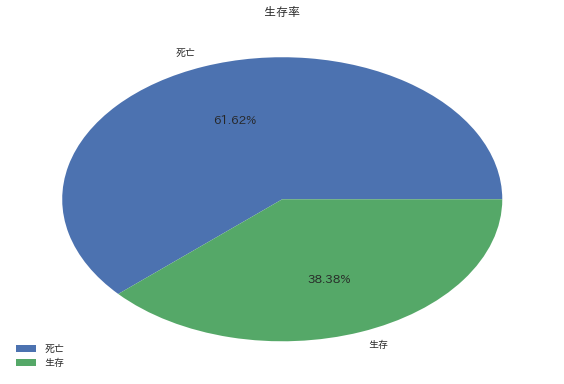

In [6]:
grouped.plot.pie(title='生存率', autopct='%.2f%%', legend=True, label='')

factorplotで男女でどのくらいの人数差があったかを表示。factorplotでカテゴリカルデータを集計するにはkind='count'を指定する。
指定しなかった場合

```
TypeError: unsupported operand type(s) for /: 'str' and 'int'
```

というエラーが出てしまう。

/Users/ken/.pyenv/versions/3.6.0/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


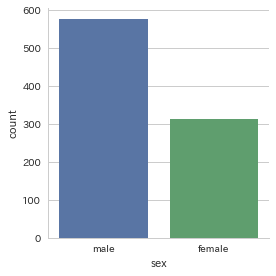

In [7]:
sns.factorplot('sex', data=df, kind='count')

factorplotではhueオプションを使うことで、集計結果をさらに細分化できる。
legend=Falseとしたのは、legendの場所がデフォルトだとそのまま右下に出て、グラフとかぶって見にくかったため、
改めてplt.legendを使って描画し直した。

/Users/ken/.pyenv/versions/3.6.0/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


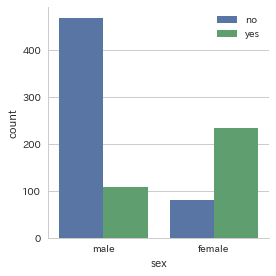

In [8]:
sns.factorplot('sex', data=df, hue='alive', kind='count', legend=False)
plt.legend(loc='upper right')

どの乗車クラスに男性、女性、子供がどれくらい乗っていたかもプロットする。

/Users/ken/.pyenv/versions/3.6.0/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


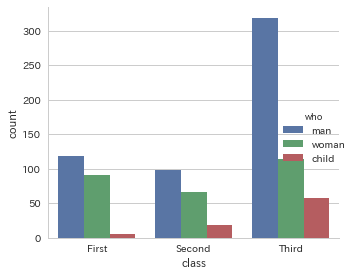

In [9]:
sns.factorplot('class', data=df, hue='who', kind='count')

年齢のヒストグラムをプロット。

/Users/ken/.pyenv/versions/3.6.0/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


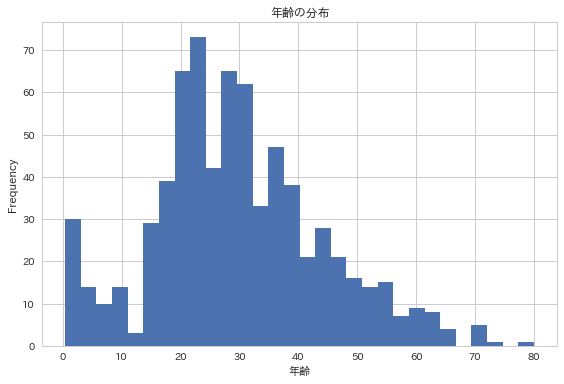

In [10]:
df.age.plot.hist(bins=30, title='年齢の分布')
plt.xlabel('年齢')

乗車クラスと乗車料金と年齢でプロット。
返り値で受け取ったAxesオブジェクト(axという変数に格納)を、二番目以降のplotに渡さないとグラフが別々になってしまう。

/Users/ken/.pyenv/versions/3.6.0/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


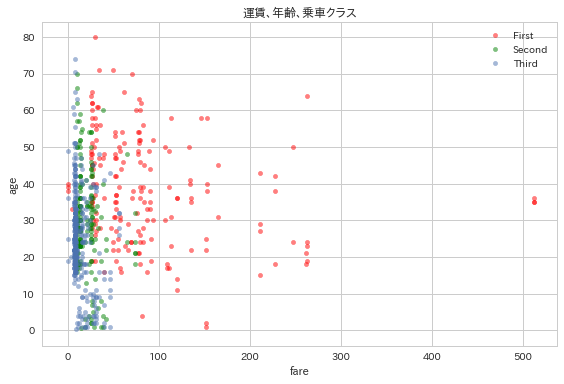

In [11]:
ax = df[df['class'] == 'First'].plot.scatter('fare', 'age', c='red',
                                             alpha=0.5, title='運賃、年齢、乗車クラス',
                                             label='First')
df[df['class'] == 'Second'].plot.scatter('fare', 'age', c='green', alpha=0.5, ax=ax,
                                         label='Second')
df[df['class'] == 'Third'].plot.scatter('fare', 'age', alpha=0.5, ax=ax,
                                        label='Third')

# ロジスティック回帰
説明変数として、年齢(age)、性別(sex)、乗車クラス(class)、乗車都市(embark_town)を利用して、目的変数は生きていたかどうか(survived)を利用する。

まずは、年齢、乗車都市がないデータを削除する。

In [12]:
dropped = df.dropna(subset=['age', 'embark_town'])

## 目的変数を定義

In [13]:
y = dropped.survived

## 説明変数を定義

カテゴリカルデータをダミー変数に変換する。
ダミー変数に変換するにはget_dummies関数を利用。
get_dummiesは次のような挙動をする。

In [14]:
dropped.embark_town.str.get_dummies().head()

,Cherbourg,Queenstown,Southampton
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [15]:
x = pd.concat([
               dropped.age,
               dropped.sex.str.get_dummies(),
               dropped.embark_town.str.get_dummies(),
               pd.get_dummies(dropped['class'])
              ], axis=1)
x.head()

,age,female,male,Cherbourg,Queenstown,Southampton,First,Second,Third
0,22.0,0,1,0,0,1,0,0,1
1,38.0,1,0,1,0,0,1,0,0
2,26.0,1,0,0,0,1,0,0,1
3,35.0,1,0,0,0,1,1,0,0
4,35.0,0,1,0,0,1,0,0,1


## トレーニングデータとテストデータを分割
train_test_splitを利用してトレーニングデータとテストデータを分割する。

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

## ロジスティック回帰を適用

トレーニングデータから学習

In [17]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

テストデータから予測

In [18]:
predicted_y = lr.predict(x_test)
predicted_y

array([1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 1])

## 評価
まずは正解データの割合を見てみる。

In [19]:
print(y_test.value_counts().apply(lambda x: x/len(y_test)))

0    0.622378
1    0.377622
Name: survived, dtype: float64


全部を0にしても6割の精度となる。

次にlogistic回帰で予測した場合の精度。

In [20]:
accuracy_score(y_true=y_test, y_pred=predicted_y)

0.72027972027972031

72%なので適当に予想するよりも精度が高くなっていることが分かる。

混合行列も出してみる

In [21]:
confusion_matrix(y_true=y_test, y_pred=predicted_y)

array([[70, 19],
       [21, 33]])